# iQuHack 2026 - Quantum Entanglement Distillation Game

! 62 points in initial test

This search algorithm is very similar to the explosive BARCS protocol, except that it lowers the weight for bonus points
to encourage the model to focus on the ones adjacent to the bonuses, which are more likely to be cluster points. This has
the added effect of keeping the model from over-stratifying itself and losing points.

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [1]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import json
from pathlib import Path

## Session Management

Save/load your session to avoid re-registering.

In [2]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

In [3]:
# Try to resume existing session
client = load_session()

if not client:
    print("No saved session. Register below.")

No saved session. Register below.


## Step 1: Register

Skip this if you resumed a session above.

In [4]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()
    
    # CHANGE THESE to your unique values
    PLAYER_ID = "willignoresbonuses"
    PLAYER_NAME = "will ott"
    
    result = client.register(PLAYER_ID, PLAYER_NAME, location=input("remote or in_person: ").strip())
    
    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

Registered! Token: HBh_dmfV6xLuYXAf4eX-...

Starting candidates (4):
  - Qingdao, China: 4 qubits, +0 bonus
  - Perth, Australia: 3 qubits, +0 bonus
  - Sendai, Japan: 3 qubits, +0 bonus
  - Bangalore, India: 5 qubits, +1 bonus
Session saved.


## Step 2: Select Starting Node

In [5]:
status = client.get_status()

if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    result = client.select_starting_node("Bangalore, India")
    print(result)

Select a starting node from the candidates shown above.
{'ok': True, 'data': {'success': True, 'starting_node': 'Bangalore, India', 'score': 0, 'budget': 40}}


## Step 3: Explore the Network

In [6]:
client.print_status()

Player: willignoresbonuses (will ott)
Score: 0 | Budget: 40 bell pairs
Active: Yes
Starting node: Bangalore, India
Owned: 1 nodes, 0 edges
Claimable edges: 5
  - ['Bangalore, India', 'Chennai, India']: threshold=0.90, difficulty=2
  - ['Bangalore, India', 'Hyderabad, India']: threshold=0.90, difficulty=3
  - ['Bangalore, India', 'Colombo, Sri Lanka']: threshold=0.92, difficulty=4
  ... and 2 more


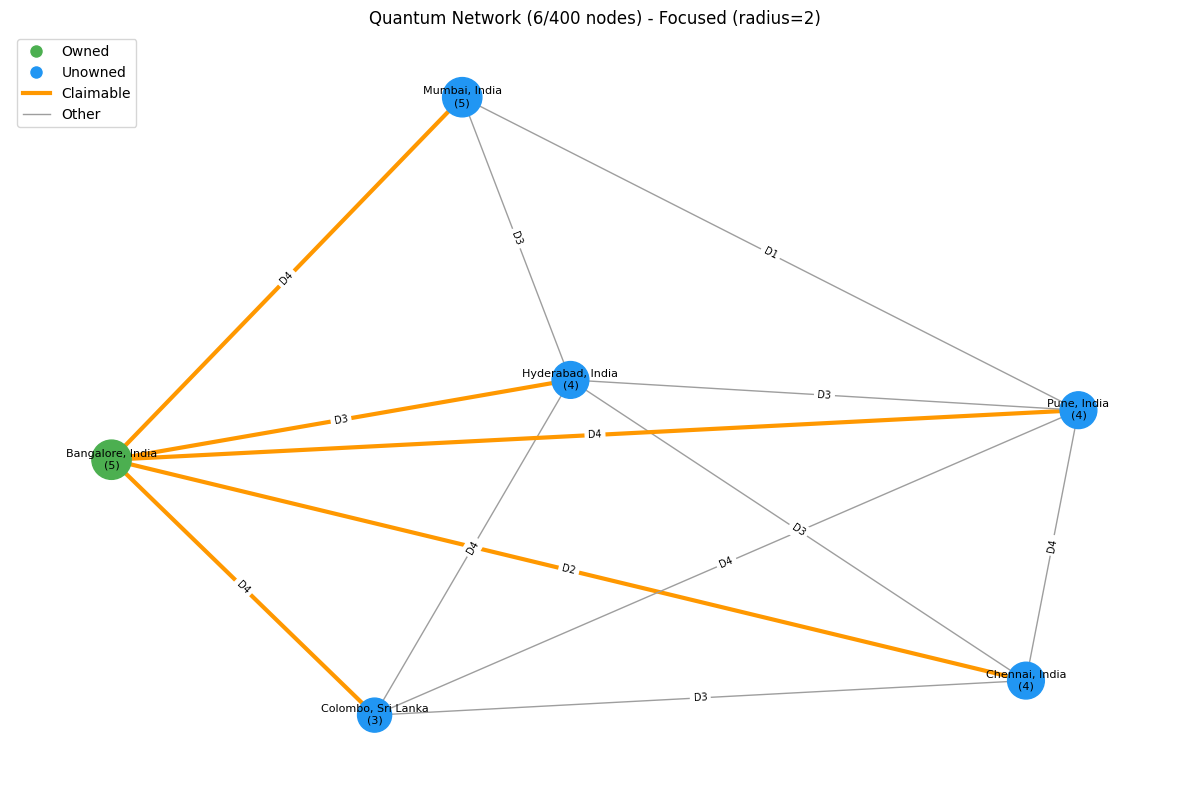

In [7]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

In [8]:
#DONT TOUCH THIS CELL WORKS PERFECTLY

import networkx as nx
from client import GameClient

# 1. Initialize and load data
viz = GraphTool(client.get_cached_graph())

# 2. Generate the layout (Creates abstract coordinates between -1 and 1)
calculated_pos = nx.spring_layout(viz.graph, seed=42)

# 3. Helper to scale -1...1 to a pixel grid (e.g., 0...1000)
def scale_coords(val, size=1000):
    return int((val + 1) * (size / 2))

# 4. Build your analysis dictionary
node_analysis = {}

for node_id, data in viz.nodes.items():
    # Grab the raw coordinates we calculated in step 2
    raw_x = calculated_pos[node_id][0]
    raw_y = calculated_pos[node_id][1]
    
    node_analysis[node_id] = {
        "x": raw_x,
        "y": raw_y,
        "x_pixel": scale_coords(raw_x, size=1000), # Scaled for simulation
        "y_pixel": scale_coords(raw_y, size=1000), # Scaled for simulation
        "points": data.get("utility_qubits", 0),
        "bonus": data.get("bonus_bell_pairs", 0)
    }

print(node_analysis)

#----- Everything above here is working. It provides a dictionary with coordinates and node info, including scaled pixel map coords -----#
#----- The pixel map coords can be used to simulate distances between nodes in the event that we want to draw maps -----#

{'College Park, MD': {'x': np.float64(-0.514219132463326), 'y': np.float64(0.16578065445529178), 'x_pixel': 242, 'y_pixel': 582, 'points': 1, 'bonus': 2}, 'Bothell, WA': {'x': np.float64(0.05795101585353622), 'y': np.float64(-0.28594309991900857), 'x_pixel': 528, 'y_pixel': 357, 'points': 1, 'bonus': 0}, 'Rome, NY': {'x': np.float64(-0.5323415758139002), 'y': np.float64(0.009738552171849185), 'x_pixel': 233, 'y_pixel': 504, 'points': 1, 'bonus': 0}, 'Chattanooga, TN': {'x': np.float64(-0.2301507385966261), 'y': np.float64(0.8046651479412402), 'x_pixel': 384, 'y_pixel': 902, 'points': 2, 'bonus': 0}, 'Chicago, IL': {'x': np.float64(-0.030326951857730426), 'y': np.float64(0.4414443124290479), 'x_pixel': 484, 'y_pixel': 720, 'points': 5, 'bonus': 2}, 'Toronto, Canada': {'x': np.float64(-0.6394793090388292), 'y': np.float64(0.3918664772262042), 'x_pixel': 180, 'y_pixel': 695, 'points': 5, 'bonus': 1}, 'Vista, CA': {'x': np.float64(0.3061981150213237), 'y': np.float64(0.14309202700861248), 

In [9]:
import networkx as nx

#DONT TOUCH THIS CELL WORKS PERFECTLY

# Initialize the empty graph
G = nx.Graph()

# 1. Add nodes from your dictionary
for node_id, data in node_analysis.items():
    G.add_node(node_id, 
               pos=(data['x'], data['y']), # Coordinates for visualization
               points=data['points'],      # Utility Qubits
               bonus=data['bonus'])        # Starting bonus

# 2. Add edges from your viz object
# This connects the nodes so NetworkX can find paths
for (u, v), edge_data in viz.edges.items():
    # Use 'base_threshold' as the 'weight' (the cost to travel this edge)
    G.add_edge(u, v,
                weight=edge_data.get('base_threshold', 1.0), 
                difficulty_rating=edge_data.get('difficulty_rating', 1))

print(f"Graph G is now ready with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges!")

import matplotlib.pyplot as plt

def analyze_quantum_targets_with_clusters(G, start_node, depth=1):
    """
    Ranks nodes based on their own value PLUS the value of their immediate neighborhood.
    """
    centrality = nx.betweenness_centrality(G, weight='weight')
    costs = nx.single_source_dijkstra_path_length(G, start_node, weight='weight')
    
    results = []
    
    for node_id in G.nodes():
        if node_id == start_node: continue
            
        # 1. Base Points of the node itself
        base_points = G.nodes[node_id].get('points', 0)
        
        # 2. CLUSTER SCOUTING: Sum the points of all adjacent unowned neighbors
        # This tells the ROI: 'This node is worth X, but it leads to Y more points.'
        neighborhood_points = 0
        for neighbor in G.neighbors(node_id):
            # We add a fraction of the neighbor's points to the 'Value' of this node
            neighborhood_points += G.nodes[neighbor].get('points', 0) * 0.5 
            
        total_strategic_utility = base_points + neighborhood_points
        
        cost = costs.get(node_id, float('inf'))
        strategic_value = centrality.get(node_id, 0)
        
        # We still use your Aggressive ROI (Points Squared) but apply it to the cluster utility
        roi = (total_strategic_utility ** 2) / (cost + 1)
        combined_score = roi * (1 + strategic_value)
        
        results.append({
            "node": node_id,
            "roi": roi,
            "strategic_importance": strategic_value,
            "combined_score": combined_score,
            "total_cost": cost,
            "points": base_points,
            "cluster_bonus": neighborhood_points
        })

    results.sort(key=lambda x: x['combined_score'], reverse=True)
    return results

#Above this line is working and defines the function analyze_quantum_targets

# --- EXECUTION (Corrected) ---

# 1. FETCH FRESH STATUS: Ensures the 'starting_node' key actually exists and is current
status = client.get_status()

# 2. SAFELY ACCESS STARTING NODE: Prevents KeyError if the API structure changed
my_start = (
    status.get('starting_node') or 
    status.get('data', {}).get('starting_node') or 
    status.get('player_info', {}).get('starting_node')
)

if not my_start:
    # Fallback to the first owned node if starting_node is missing
    owned_nodes = status.get('owned_nodes', [])
    if owned_nodes:
        my_start = owned_list[0]
        print(f"⚠️ 'starting_node' not found; using fallback: {my_start}")
    else:
        raise ValueError("Critical: No owned nodes or starting node found. Check registration.")

# 3. RUN ANALYSIS
targets = analyze_quantum_targets_with_clusters(G, my_start, 2)

print(f"--- STRATEGIC TARGETS FROM {my_start} ---")
for t in targets[:10]:
    print(f"Node: {t['node']:<15} | ROI: {t['roi']:.2f} | Strategy: {t['strategic_importance']:.2f} | Score: {t['combined_score']:.2f}")

Graph G is now ready with 400 nodes and 1057 edges!
--- STRATEGIC TARGETS FROM Bangalore, India ---
Node: Mumbai, India   | ROI: 379.69 | Strategy: 0.35 | Score: 512.38
Node: Singapore       | ROI: 319.15 | Strategy: 0.34 | Score: 426.18
Node: Tokyo, Japan    | ROI: 202.21 | Strategy: 0.26 | Score: 254.08
Node: Hong Kong       | ROI: 180.75 | Strategy: 0.09 | Score: 196.86
Node: Pune, India     | ROI: 188.02 | Strategy: 0.00 | Score: 188.53
Node: Sydney, Australia | ROI: 128.72 | Strategy: 0.03 | Score: 132.82
Node: Cairo, Egypt    | ROI: 95.86 | Strategy: 0.32 | Score: 126.61
Node: Taichung, Taiwan | ROI: 114.01 | Strategy: 0.01 | Score: 115.16
Node: Hyderabad, India | ROI: 110.66 | Strategy: 0.00 | Score: 111.09
Node: Nanjing, China  | ROI: 103.60 | Strategy: 0.02 | Score: 105.36


In [10]:
#DONT TOUCH THIS CELL WORKS PERFECTLY

import networkx as nx
import matplotlib.pyplot as plt

def render_focused_heatmap(G, start_node, max_cost=5.0):
    """
    Renders a heatmap that only shows nodes within a certain 'cost' distance.
    """
    # 1. Calculate costs and strategic value
    costs = nx.single_source_dijkstra_path_length(G, start_node, weight='weight')
    centrality = nx.betweenness_centrality(G, weight='weight')
    
    # 2. Filter nodes based on the cutoff
    # We only keep nodes where cost <= max_cost
    visible_nodes = [n for n in G.nodes() if costs.get(n, float('inf')) <= max_cost]
    
    # Create a subgraph for a cleaner visual
    sub_G = G.subgraph(visible_nodes)
    
    # 3. Prepare plotting data
    node_list = list(sub_G.nodes())
    scores = []
    node_sizes = []
    
    for node in node_list:
        points = sub_G.nodes[node].get('points', 0)
        cost = costs[node]
        strat = centrality.get(node, 0)
        
        # Calculate score (ROI + Centrality)
        roi = points / (cost + 1)
        score = roi * (1 + strat)
        
        scores.append(score if node != start_node else 0)
        node_sizes.append(150 + points * 180)

    # 4. Render
    plt.figure(figsize=(12, 8), dpi=120)
    pos = nx.get_node_attributes(sub_G, 'pos')
    
    # Draw local edges
    nx.draw_networkx_edges(sub_G, pos, alpha=0.3, edge_color="#666666")
    
    # Draw heatmap
    nodes = nx.draw_networkx_nodes(
        sub_G, pos, 
        nodelist=node_list,
        node_size=node_sizes,
        node_color=scores,
        cmap=plt.cm.YlOrRd,
        edgecolors='black',
        linewidths=0.8
    )

    # Labels for everything in the focused view
    nx.draw_networkx_labels(sub_G, pos, font_size=8, font_weight='bold')

    plt.title(f"Strategic Neighborhood (Cost Cutoff: {max_cost})\nOrigin: {start_node}", fontsize=14)
    plt.colorbar(nodes, label='Strategic Priority')
    plt.axis('off')
    plt.show()

# Run with a cost cutoff of budget*0.1 (Adjust based on your budget!)

#render_focused_heatmap(G, status['starting_node'], status['budget'] * 0.1)

In [11]:
def get_next_best_path(G, start_node, search_context):
    """
    Finds an unowned target and ensures the path doesn't travel through blacklisted nodes.
    """
    # 1. Recalculate ROI strategic scores
    targets = analyze_quantum_targets_with_clusters(G, start_node, 2)
    # 2. Filter: The destination must not be owned or blacklisted
    eligible = [t for t in targets if t['node'] not in search_context]
    
    if not eligible:
        return None, []

    # 3. Try targets in order of ROI until a valid path is found
    for target_data in eligible:
        best_target = target_data['node']
        
        # 4. SUBGRAPH: Effectively 'deletes' blacklisted nodes for this calculation
        # We allow owned nodes for travel, but NOT blacklisted nodes
        allowed_nodes = [n for n in G.nodes() if n not in search_context or n in server_owned or n == best_target]
        temp_G = G.subgraph(allowed_nodes)
        
        try:
            path = nx.shortest_path(temp_G, source=start_node, target=best_target, weight='weight')
            print(f"🧠 Brain: Valid path found to {best_target} ({len(path)} steps)")
            return best_target, path
        except nx.NetworkXNoPath:
            # This destination is unreachable without hitting a blacklisted node. Skip to next ROI target.
            continue 

    return None, []

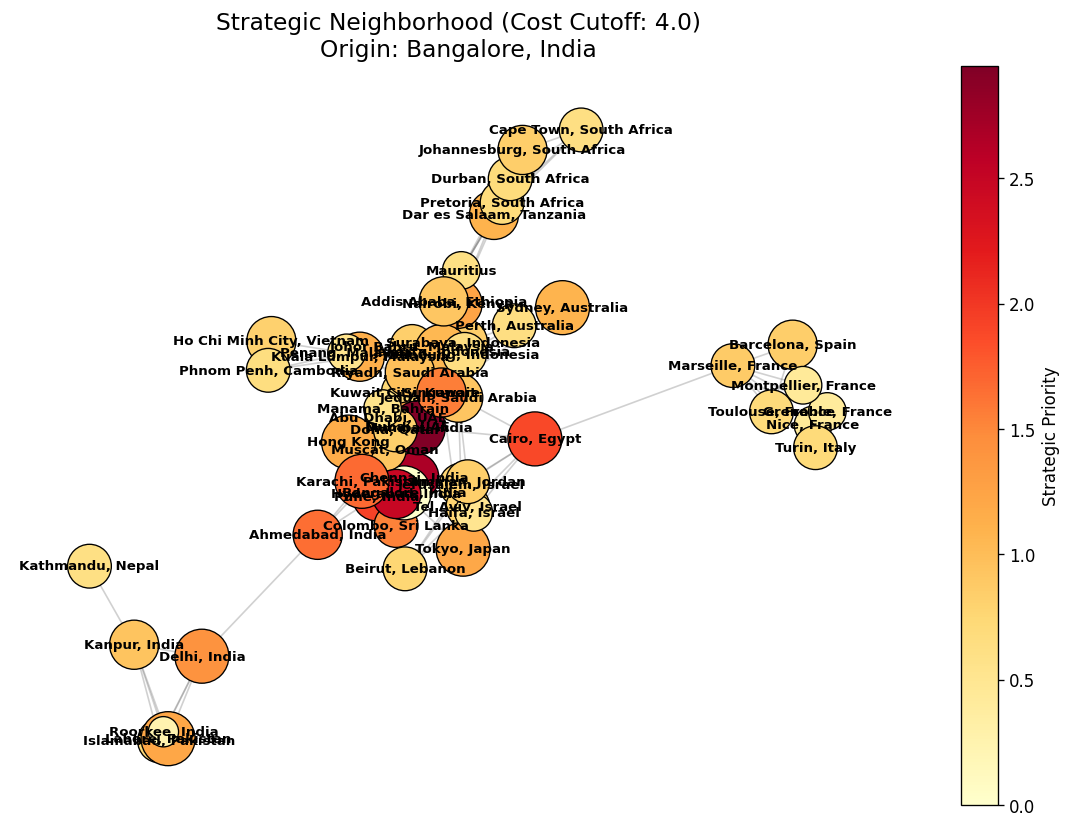

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import random

# 1. INITIALIZE DATA & GRAPH
# Fetch the latest game state to ensure G is accurate
status = client.get_status()
viz = GraphTool(client.get_cached_graph())

# --- UPDATED GRAPH CONSTRUCTION ---
G = nx.Graph()

for node_id, data in node_analysis.items():
    G.add_node(node_id, 
               pos=(data['x'], data['y']), 
               points=data['points'],      
               bonus=data['bonus'])

for (u, v), edge_data in viz.edges.items():
    base_weight = edge_data.get('base_threshold', 1.0)
    difficulty = edge_data.get('difficulty_rating', 1)
    
    # 1. PREFER EASY PATHS: Multiply D4+ by 2.5 to make them 'expensive'
    diff_multiplier = 1.0
    if difficulty >= 4:
        diff_multiplier = 2.5 
    elif difficulty <= 2:
        diff_multiplier = 0.8 # Bias toward D1/D2
        
    # 2. BONUS SNIPING: 30% discount if either node has a bonus
    bonus_multiplier = 0.5
    if G.nodes[u].get('bonus', 0) > 0 or G.nodes[v].get('bonus', 0) > 0:
        bonus_multiplier = 0.7 
    
    G.add_edge(u, v,
                weight=base_weight * diff_multiplier * bonus_multiplier, 
                difficulty_rating=difficulty)

# Create a stable layout for visualization
pos = nx.spring_layout(G, seed=42) 


# 3. UPDATED DASHBOARD (Without Path Highlight)
render_focused_heatmap(G, status['starting_node'], status['budget'] * 0.1)
    

# 4. START THE MARCH
#status = client.get_status()
my_start = status['starting_node']
my_owned = set(status.get('owned_nodes', [my_start]))

## Step 5: Claim an Edge

In [13]:
# Find claimable edges
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted[:5]:
    print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (5):
  ['Bangalore, India', 'Chennai, India'] - threshold: 0.900, difficulty: 2
  ['Bangalore, India', 'Hyderabad, India'] - threshold: 0.900, difficulty: 3
  ['Bangalore, India', 'Colombo, Sri Lanka'] - threshold: 0.920, difficulty: 4
  ['Bangalore, India', 'Pune, India'] - threshold: 0.920, difficulty: 4
  ['Bangalore, India', 'Mumbai, India'] - threshold: 0.920, difficulty: 4


In [14]:
#ATTACK CIRCUITS BELOW

# =========================
# Run D2 circuit on a specific SOURCE <-> TARGET edge and print stats
# Copy/paste this whole cell
# =========================

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_d2_circuit():
    # N=2 -> 4 qubits total, 3 classical bits (c2 is flag)
    qr = QuantumRegister(4, "q")
    cr = ClassicalRegister(3, "c")
    qc = QuantumCircuit(qr, cr)

    # Convert phase flips -> bit flips
    qc.h(qr)

    # Bilateral parity check (output pair q1,q2 controls sacrificial q0,q3)
    qc.cx(qr[1], qr[0])   # Alice side
    qc.cx(qr[2], qr[3])   # Bob side

    # Measure sacrificial qubits
    qc.measure(qr[0], cr[0])
    qc.measure(qr[3], cr[1])

    # Restore basis on output pair
    qc.h(qr[1])
    qc.h(qr[2])

    # Flag = c0 XOR c1 (keep if flag_bit == 0)
    qc.store(cr[2], expr.bit_xor(cr[0], cr[1]))

    return qc


def run_d2_on_edge(client, source_city: str, target_city: str):
    # Find that exact edge among claimable edges
    claimable = client.get_claimable_edges()
    want = {source_city, target_city}
    target_edge = next((e for e in claimable if set(e["edge_id"]) == want), None)

    if target_edge is None:
        print(f"Edge {source_city} <-> {target_city} is NOT currently claimable.")
        print("Some claimable edges (first 12):")
        for e in claimable[:12]:
            print(f"  {tuple(e['edge_id'])} | diff={e['difficulty_rating']} | thr={e['base_threshold']}")
        return None

    edge_id = tuple(target_edge["edge_id"])

    result = client.claim_edge(
        edge=edge_id,
        circuit=get_d2_circuit(),
        flag_bit=2,        # <-- c[2]
        num_bell_pairs=2   # <-- N=2
    )

    if not result.get("ok"):
        print("FAILED:", result.get("error", {}).get("code"), "-", result.get("error", {}).get("message"))
        return result

    data = result["data"]
    F = float(data.get("fidelity", 0.0))
    p = float(data.get("success_probability", 0.0))

    print(f"Success: {data.get('success')}")
    print(f"Fidelity: {F:.4f} (threshold: {float(data.get('threshold', 0.0)):.4f})")
    print(f"Success probability: {p:.4f}")
    print(f"Claim strength added (f*p): {F*p:.4f}")

    return result


# ---- EDIT THESE ----
#SOURCE = "Buenos Aires, Argentina"
#TARGET = "Rosario, Argentina"  # replace with a D2 edge you can claim

#run_d2_on_edge(client, SOURCE, TARGET)

# =========================
# D3 optimal N=3 (Phi+/Psi+) circuit + runner (QASM3, same style as your working D2/D4)
# Copy/paste this whole cell
# =========================

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
from qiskit import qasm3

def get_d3_opt_circuit_N3():
    """
    D3 noise (your measured model): rho = 0.75|Phi+><Phi+| + 0.25|Psi+><Psi+|
    This is "bit-flip-type" (Psi+ corresponds to an X error relative to Phi+).

    N=3 protocol (recurrence):
      - 2 sacrificial pairs + 1 output pair
      - Do bilateral parity checks from the output pair onto BOTH sacrificial pairs
      - Measure sacrificial qubits and postselect that BOTH parity syndromes are 0
      - Keep output pair (q2,q3)

    Pairing for N=3 (2N=6, outside-in):
      Pair0: (q0, q5)  sacrificial
      Pair1: (q1, q4)  sacrificial
      Pair2: (q2, q3)  output  <-- keep

    Expected (theory) for F=0.75:
      p_succ = F^3 + (1-F)^3 = 0.4375
      F_out  = F^3 / (F^3 + (1-F)^3) ≈ 0.9642857
    """

    qr = QuantumRegister(6, "q")          # 2N = 6 qubits
    cr = ClassicalRegister(7, "c")        # c0..c3 meas, c4 s0, c5 s1, c6 flag
    qc = QuantumCircuit(qr, cr)

    # --- Bilateral parity checks from output pair (q2,q3) -> sacrificial pairs ---
    # check output vs Pair0 (q0,q5)
    qc.cx(qr[2], qr[0])   # Alice side
    qc.cx(qr[3], qr[5])   # Bob side

    # check output vs Pair1 (q1,q4)
    qc.cx(qr[2], qr[1])   # Alice side
    qc.cx(qr[3], qr[4])   # Bob side

    # --- Measure sacrificial qubits ---
    qc.measure(qr[0], cr[0])  # Alice (pair0)
    qc.measure(qr[1], cr[1])  # Alice (pair1)
    qc.measure(qr[5], cr[2])  # Bob   (pair0)
    qc.measure(qr[4], cr[3])  # Bob   (pair1)

    # --- Build syndromes then flag with parser-friendly simple assignments ---
    qc.store(cr[4], expr.bit_xor(cr[0], cr[2]))  # s0 = c0 ^ c2
    qc.store(cr[5], expr.bit_xor(cr[1], cr[3]))  # s1 = c1 ^ c3
    qc.store(cr[6], expr.bit_or(cr[4], cr[5]))   # flag = s0 | s1  (keep iff flag == 0)

    return qc


def run_d3_n3_on_edge(client, source_city: str, target_city: str, verbose_qasm_tail: int = 0):
    """
    Finds the specific claimable edge SOURCE <-> TARGET, submits D3 N=3 circuit,
    and prints stats in your preferred format.
    """
    claimable = client.get_claimable_edges()
    want = {source_city, target_city}
    target_edge = next((e for e in claimable if set(e["edge_id"]) == want), None)

    if target_edge is None:
        print(f"Edge {source_city} <-> {target_city} is NOT currently claimable.")
        print("Some claimable edges (first 12):")
        for e in sorted(claimable, key=lambda x: (x["difficulty_rating"], x["base_threshold"]))[:12]:
            print(f"  {tuple(e['edge_id'])} | diff={e['difficulty_rating']} | thr={e['base_threshold']}")
        return None

    edge_id = tuple(target_edge["edge_id"])
    diff = int(target_edge.get("difficulty_rating", -1))
    thr  = float(target_edge.get("base_threshold", 0.0))

    print(f"Attacking edge: {edge_id} | diff={diff} | thr={thr:.2f}")
    if diff != 3:
        print("WARNING: This circuit is tuned for D3 (Phi+/Psi+ mixture).")

    circuit = get_d3_opt_circuit_N3()

    if verbose_qasm_tail > 0:
        q = qasm3.dumps(circuit).splitlines()
        print("\n=== QASM3 tail preview ===")
        print("\n".join(q[-verbose_qasm_tail:]))
        print("=========================\n")

    # IMPORTANT:
    # - N=3
    # - flag is c[6]
    result = client.claim_edge(
        edge=edge_id,
        circuit=circuit,
        flag_bit=6,
        num_bell_pairs=3
    )

    if not result.get("ok"):
        print("FAILED:", result.get("error", {}).get("code"), "-", result.get("error", {}).get("message"))
        return result

    data = result["data"]
    F = float(data.get("fidelity", 0.0))
    p = float(data.get("success_probability", 0.0))

    print(f"Success: {data.get('success')}")
    print(f"Fidelity: {F:.4f} (threshold: {float(data.get('threshold', 0.0)):.4f})")
    print(f"Success probability: {p:.4f}")
    print(f"Claim strength added (f*p): {F*p:.4f}")

    return result

# If you want to inspect the last lines of QASM3:
# run_d3_n3_on_edge(client, SOURCE, TARGET, verbose_qasm_tail=25)

#run_d3_n3_on_edge(client, SOURCE, TARGET)


# =========================
# D4 optimal N=3 submit helper (QASM3, no fallback)
# Paste this whole cell, then set SOURCE/TARGET at bottom and run.
# =========================

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
from qiskit import qasm3

def get_d4_opt_circuit_N3():
    """
    D4 (phase-flip-only) N=3 protocol with QASM3-safe classical logic.
    Uses 2 sacrificial pairs + 1 output pair.
    Postselect on flag_bit = c[6] == 0.
    """
    qr = QuantumRegister(6, "q")          # 2N = 6 qubits
    cr = ClassicalRegister(7, "c")        # need temps: c[4], c[5], flag c[6]
    qc = QuantumCircuit(qr, cr)

    # 1) Convert phase flips -> bit flips
    for i in range(6):
        qc.h(qr[i])

    # Pairing for N=3:
    # sacrificial: (q0,q5) and (q1,q4)
    # output:      (q2,q3)  <-- keep

    # 2) Two bilateral parity checks from output -> sacrificial
    qc.cx(qr[2], qr[0])  # Alice
    qc.cx(qr[3], qr[5])  # Bob
    qc.cx(qr[2], qr[1])  # Alice
    qc.cx(qr[3], qr[4])  # Bob

    # 3) Measure sacrificial qubits
    qc.measure(qr[0], cr[0])
    qc.measure(qr[1], cr[1])
    qc.measure(qr[5], cr[2])
    qc.measure(qr[4], cr[3])

    # 4) Restore basis on output pair (so fidelity is measured vs Phi+)
    qc.h(qr[2])
    qc.h(qr[3])

    # 5) Build syndromes then flag with ONLY simple assignments (QASM3 parser-friendly)
    qc.store(cr[4], expr.bit_xor(cr[0], cr[2]))  # s0 = c0 ^ c2
    qc.store(cr[5], expr.bit_xor(cr[1], cr[3]))  # s1 = c1 ^ c3
    qc.store(cr[6], expr.bit_or(cr[4], cr[5]))   # flag = s0 | s1

    return qc


def conquer_edge_with_d4_n3(client, source_city: str, target_city: str, verbose_qasm_tail: int = 0):
    """
    Finds the specific claimable edge between source_city and target_city,
    submits the D4 N=3 circuit, and prints results + updated status.
    """
    claimable = client.get_claimable_edges()
    if not claimable:
        print("No claimable edges right now (do you own at least one node?).")
        return None

    want = {source_city, target_city}
    target_edge = next((e for e in claimable if set(e["edge_id"]) == want), None)

    if target_edge is None:
        print(f"Edge {source_city} <-> {target_city} is NOT currently claimable from your owned nodes.")
        print("Some claimable edges (first 12):")
        for e in claimable[:12]:
            print(f"  {tuple(e['edge_id'])} | diff={e['difficulty_rating']} | thr={e['base_threshold']}")
        return None

    edge_id = tuple(target_edge["edge_id"])
    diff = int(target_edge.get("difficulty_rating", -1))
    thr  = float(target_edge.get("base_threshold", 0.0))

    print(f"Attacking edge: {edge_id} | difficulty={diff} | threshold={thr:.2f}")
    if diff != 4:
        print("WARNING: This edge is not difficulty 4. This circuit is tuned for D4 (phase-flip-only).")

    circuit = get_d4_opt_circuit_N3()

    # Optional: print tail of QASM3 for debugging
    if verbose_qasm_tail > 0:
        q = qasm3.dumps(circuit).splitlines()
        print("\n=== QASM3 tail preview ===")
        print("\n".join(q[-verbose_qasm_tail:]))
        print("=========================\n")

    # IMPORTANT:
    # - N=3
    # - flag is c[6]
    result = client.claim_edge(
        edge=edge_id,
        circuit=circuit,
        flag_bit=6,
        num_bell_pairs=3
    )

    if not result.get("ok"):
        print("FAILED:", result.get("error", {}).get("code"), "-", result.get("error", {}).get("message"))
        return result

    data = result.get("data", {})
    F = float(data.get("fidelity", 0.0))
    p = float(data.get("success_probability", 0.0))
    print(f"Success: {data.get('success')}")
    print(f"Fidelity: {F:.4f} (threshold: {float(data.get('threshold', 0.0)):.4f})")
    print(f"Success probability: {p:.4f}")
    print(f"Claim strength added (f*p): {F*p:.4f}")

    status = client.get_status()
    print("\n--- Updated Player Status ---")
    print(f"Score: {status.get('score', 0)}")
    print(f"Budget: {status.get('budget', 0)}")
    print(f"Owned nodes: {len(status.get('owned_nodes', []))}")
    print(f"Owned edges: {len(status.get('owned_edges', []))}")
    print("----------------------------\n")

    return result


In [15]:
# --- FINAL HYBRID v2: BARCS + CLUSTER GREEDY + DESPERATION DASH ---
local_blacklist = set()
locally_captured = set()

while True:
    # 1. GROUND TRUTH: Refresh server status and local memory
    status = client.get_status()
    current_budget = status.get('budget', 0)
    server_owned = set(status.get('owned_nodes', []))
    
    # search_context creates the 'Forbidden Zone' for the ROI brain
    search_context = server_owned.union(locally_captured).union(local_blacklist)

    possible_moves = []
    
    # 2. EMPIRE-WIDE OPPORTUNITY SCAN
    for owned_node in server_owned:
        # Use your Cluster Scouting function to evaluate the world
        targets = analyze_quantum_targets_with_clusters(G, owned_node)
        
        for t in targets:
            # Filter for unowned, non-blacklisted, immediate neighbors
            if t['node'] not in search_context and G.has_edge(owned_node, t['node']):
                edge_diff = G[owned_node][t['node']].get('difficulty_rating', 1)
                required_n = 3 if edge_diff >= 3 else 2
                
                # BUDGET GUARDRAIL: Only proceed if we can afford the circuit
                if current_budget >= required_n:
                    
                    # --- MODE SELECTION LOGIC ---
                    is_desperation = current_budget < 6
                    is_cluster_greedy = t['cluster_bonus'] > 15 # We are 'in' a high-value cluster
                    
                    if is_desperation:
                        # DESPERATION: Prioritize pure point efficiency
                        final_score = (t['points'] / required_n)
                    elif is_cluster_greedy:
                        # CLUSTER GREEDY: Ignore distance/strategy to 'clean out' the neighborhood
                        final_score = t['points'] * 10 
                    else:
                        # NORMAL BARCS: Cluster-weighted ROI calculation
                        final_score = t['combined_score']

                    possible_moves.append({
                        "source": owned_node,
                        "target": t['node'],
                        "score": final_score,
                        "points": t['points'],
                        "is_greedy": is_cluster_greedy,
                        "cost_n": required_n
                    })
                    break # Best option found for this frontier node

    # 3. SAFETY CHECK: Exit if no winnable/affordable moves remain
    if not possible_moves:
        print("🚩 Mission Complete: Budget exhausted or territory claimed.")
        break

    # 4. SELECTION: Sort by score (Highest first)
    possible_moves.sort(key=lambda x: x['score'], reverse=True)
    best_move = possible_moves[0]
    source_city, next_hop = best_move['source'], best_move['target']

    # Mode Reporting
    if best_move.get('is_greedy'):
        print(f"🔥 [MODE] Cluster Greedy: Targeting {next_hop} for local payoff.")
    elif current_budget < 6:
        print(f"🚨 [MODE] Desperation Dash: Squeezing {next_hop} for points.")

    # 5. EXECUTION: Deterministic Distillation
    claimable = client.get_claimable_edges()
    edge_info = next((e for e in claimable if set(e["edge_id"]) == {source_city, next_hop}), None)

    success = False
    if edge_info:
        print(f"\n[WAR ROOM] Attacking: {source_city} -> {next_hop} (+{best_move['points']} pts)")
        diff = edge_info.get("difficulty_rating", 1)
        res = None
        
        # Use your established deterministic circuit runners
        if diff == 2: res = run_d2_on_edge(client, source_city, next_hop)
        elif diff == 3: res = run_d3_n3_on_edge(client, source_city, next_hop)
        elif diff == 4: res = conquer_edge_with_d4_n3(client, source_city, next_hop)

        if res and res.get("ok") and res.get("data", {}).get("success"):
            print(f"🎉 Captured {next_hop}!")
            locally_captured.add(next_hop) # Hard-sync local memory
            success = True
    
    if not success:
        # Deterministic noise means if it fails once, it's a permanent wall
        print(f"🚫 BLOCK: Adding {next_hop} to persistent blacklist.")
        local_blacklist.add(next_hop)
    
    # Refresh latency buffer
    time.sleep(1.2)

🔥 [MODE] Cluster Greedy: Targeting Mumbai, India for local payoff.

[WAR ROOM] Attacking: Bangalore, India -> Mumbai, India (+5 pts)
Attacking edge: ('Bangalore, India', 'Mumbai, India') | difficulty=4 | threshold=0.92
Success: True
Fidelity: 0.9445 (threshold: 0.9200)
Success probability: 0.3952
Claim strength added (f*p): 0.3732

--- Updated Player Status ---
Score: 5
Budget: 38
Owned nodes: 1
Owned edges: 0
----------------------------

🎉 Captured Mumbai, India!

[WAR ROOM] Attacking: Bangalore, India -> Pune, India (+4 pts)
Attacking edge: ('Bangalore, India', 'Pune, India') | difficulty=4 | threshold=0.92
Success: True
Fidelity: 0.9445 (threshold: 0.9200)
Success probability: 0.3952
Claim strength added (f*p): 0.3732

--- Updated Player Status ---
Score: 9
Budget: 35
Owned nodes: 2
Owned edges: 1
----------------------------

🎉 Captured Pune, India!

[WAR ROOM] Attacking: Bangalore, India -> Chennai, India (+4 pts)
Success: True
Fidelity: 0.9412 (threshold: 0.9000)
Success probabi

## Step 6: Check Progress

In [16]:
client.print_status()

Player: willignoresbonuses (will ott)
Score: 62 | Budget: 0 bell pairs
Active: No
Starting node: Bangalore, India
Owned: 8 nodes, 7 edges
Claimable edges: 38
  - ['Marseille, France', 'Montpellier, France']: threshold=0.90, difficulty=1
  - ['Marseille, France', 'Nice, France']: threshold=0.90, difficulty=1
  - ['Grenoble, France', 'Marseille, France']: threshold=0.90, difficulty=2
  ... and 35 more


In [ ]:
# View leaderboard
leaderboard = client.get_leaderboard()["leaderboard"]
print("Leaderboard:")
for i, p in enumerate(leaderboard[:10]):
    print(f"{i+1}. {p.get('player_id', 'Unknown'):20} Score: {p.get('score', 0)}")

## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [ ]:
# Restart game (uncomment to use)
# result = client.restart()
# print(result)